In [1]:
import importlib

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import pysam
import pyBigWig

from Modules import utils, plot_utils

In [2]:
def get_all_bowtie2_pos_by_query(bamfile: str, paired: bool):
    with pysam.AlignmentFile(bamfile, "rb") as f:
        pos = {}
        for read in f.fetch():
            rname = read.query_name
            chr_id = read.reference_name
            start = read.reference_start
            bt2_align_val = read.tags[0][1]
            if rname not in pos:
                pos[rname] = {}
            if paired:
                nstart = read.next_reference_start
                tlen = abs(read.template_length)
                if not read.is_reverse:
                    stop = start + tlen
                    if (chr_id, start, stop) not in pos[rname]:
                        pos[rname][(chr_id, start, stop)] = []
                    pos[rname][(chr_id, start, stop)].append(bt2_align_val)
                else:
                    nstop = nstart + tlen
                    pos[rname][(chr_id, nstart, nstop)].append(bt2_align_val)
            else:
                qlen = read.query_alignment_length
                stop = start + qlen
                pos[rname][(chr_id, start, stop)] = bt2_align_val
    return pos

In [3]:
# Choose one of the following
bamfile = "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/amorces_qPCR_paired_max200.sorted.bam"
paired = True
extra_suffix = "2"

# bamfile = "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/RNAg-Alu31Rev.sorted.bam"
# paired = False
# extra_suffix = ''

# bamfile = "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/RNAg-Alu31Rev-bis.sorted.bam"
# paired = False
# extra_suffix = ''

In [17]:
# Get matched pairs with alignment score from the bamfile
pos = get_all_bowtie2_pos_by_query(bamfile, paired=paired)
# Write bed files with exact matches and partial matches (i.e. all matches)
print(len(pos))
for repeat_element, positions in pos.items():
    partial_positions = list(positions.keys())
    exact_positions = [
        pos
        for pos, bt2_align_val in positions.items()
        if np.all(np.array(bt2_align_val) == 0)
    ]
    print(repeat_element, len(partial_positions), len(exact_positions))
    # for bam_list, suffix in zip(
    #     [partial_positions, exact_positions], ["partial", "exact"]
    # ):
    #     with open(
    #         f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_{repeat_element}_positions_{suffix}{extra_suffix}.bed",
    #         "w",
    #     ) as f:
    #         for chr_id, start, stop in bam_list:
    #             f.write(f"{chr_id}\t{start}\t{stop}\n")

3
Alu 70858 5928
Alpha 3071 2339
D4Z1 1013 920


In [10]:
# Check results by counting exact matches by chromosome
bedfiles = {
    "D4Z1": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_D4Z1_positions_exact2.bed",
    "Alpha": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_Alpha_positions_exact2.bed",
    "Alu": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_Alu_positions_exact2.bed",
    "RNAg-Alu31Rev": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_RNAg-Alu31Rev_positions_exact.bed",
    "RNAg-Alu31Rev-bis": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_RNAg-Alu31Rev-bis_positions_exact.bed",
}
for repid, bedfile in bedfiles.items():
    print(repid)
    df = pd.read_csv(bedfile, sep="\t", header=None)
    print(df.groupby(0).count())

D4Z1
0    924
1    924
2    924
dtype: int64
Alpha
0    2348
1    2348
2    2348
dtype: int64
Alu
0    5998
1    5998
2    5998
dtype: int64


Count bigWig file signal over identified repeats

In [3]:
# Choose appropriate bigwig signals, bed repeat intervals and signal quantiles (computed from bigwig_stats.ipynb)
bwfiles = {
    "Ctrl_pp1": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C44_trimmed_run2_paired_T2T_properonce.bw",
    "IP1_pp1": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C43_trimmed_run2_paired_T2T_properonce.bw",
    "IP2_pp1": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_run2_paired_T2T_properonce.bw",
    "Ctrl_pp1_mm3": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C44_trimmed_run2_paired_T2T_properonce_minmapq3.bw",
    "IP1_pp1_mm3": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C43_trimmed_run2_paired_T2T_properonce_minmapq3.bw",
    "IP2_pp1_mm3": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_run2_paired_T2T_properonce_minmapq3.bw",
}
bedfiles = {
    "D4Z1": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_D4Z1_positions_exact2.bed",
    "Alpha": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_Alpha_positions_exact2.bed",
    "Alu": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_Alu_positions_exact2.bed",
    "RNAg-Alu31Rev": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_RNAg-Alu31Rev_positions_exact.bed",
    "RNAg-Alu31Rev-bis": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_RNAg-Alu31Rev-bis_positions_exact.bed",
}
quantiles = pd.read_csv(
    "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/quantiles_run2_properonce.csv",
    index_col=0,
)
quantiles

,quantile_0.9,quantile_0.95,quantile_0.99,quantile_0.999
/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C44_trimmed_run2_paired_T2T_properonce.bw,6.0,7.0,9.0,14.0
/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C43_trimmed_run2_paired_T2T_properonce.bw,8.0,9.0,13.0,23.0
/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_run2_paired_T2T_properonce.bw,58.0,66.0,86.0,168.0
/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C44_trimmed_run2_paired_T2T_properonce_minmapq3.bw,6.0,7.0,9.0,12.0
/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C43_trimmed_run2_paired_T2T_properonce_minmapq3.bw,7.0,9.0,11.0,16.0
/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_run2_paired_T2T_properonce_minmapq3.bw,56.0,63.0,78.0,104.0


In [4]:
suffix = "_run2_properonce"
# Choose options:

# Count on 300bp centered on interval (default is only interval)
# suffix += "_300bp"

# Count using thresholded signal at 99e centile
# suffix += "_clipq0.99"

suffix

'_run2_properonce'

In [6]:
# Count total signal by interval
tot = {}
for file_id, bwfile in bwfiles.items():
    tot[file_id] = {}
    with pyBigWig.open(bwfile) as bw:
        for rep_id, bedfile in bedfiles.items():
            tot[file_id][rep_id] = {}
            with open(bedfile) as f:
                for line in f:
                    chr_id, start, stop, *_ = line.split()
                    start, stop = int(start), int(stop)
                    # Taking 300bp centered on bed interval
                    if "_300bp" in suffix:
                        mid = (stop + start) // 2
                        start, stop = mid - 150, mid + 150
                        stop = min(bw.chroms(chr_id) - 1, stop)
                    #################################
                    interval_sum = bw.values(chr_id, start, stop, numpy=True)
                    # Cliping signal before summing
                    if "_clipq0.99" in suffix:
                        interval_sum = np.clip(
                            interval_sum,
                            a_min=None,
                            a_max=quantiles.loc[bwfile, "quantile_0.99"],
                        )
                    #################################
                    tot[file_id][rep_id][(chr_id, start, stop)] = np.sum(interval_sum)
# Index by rep_id first and make a list of counts by file
frag_counts = {}
for rep_id in bedfiles:
    frag_counts[rep_id] = {}
    for file_id, file_tot in tot.items():
        for pos, val in file_tot[rep_id].items():
            if pos not in frag_counts[rep_id]:
                frag_counts[rep_id][pos] = []
            frag_counts[rep_id][pos].append(int(val))
frag_counts
# Store result in bed files
resbedfiles = {
    "D4Z1": f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_D4Z1_positions_exact{suffix}_frag_counts.bed",
    "Alpha": f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_Alpha_positions_exact{suffix}_frag_counts.bed",
    "Alu": f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_Alu_positions_exact{suffix}_frag_counts.bed",
    "RNAg-Alu31Rev": f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_RNAg-Alu31Rev_positions_exact{suffix}_frag_counts.bed",
    "RNAg-Alu31Rev-bis": f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_RNAg-Alu31Rev-bis_positions_exact{suffix}_frag_counts.bed",
}
for rep_id, resbedfile in resbedfiles.items():
    resbedfile = utils.safe_filename(resbedfile)
    with open(resbedfile, "w") as f:
        for (chr_id, start, stop), counts_tuple in frag_counts[rep_id].items():
            f.write(f"{chr_id}\t{start}\t{stop}")
            for count in counts_tuple:
                f.write(f"\t{count}")
            f.write("\n")

Plot enrichments

In [36]:
suffix = "_run2"
bwfiles = {
    "Ctrl": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C44_trimmed_run2_paired_T2T.bw",
    "IP1": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C43_trimmed_run2_paired_T2T.bw",
    "IP2": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_run2_paired_T2T.bw",
}
resbedfiles = {
    "D4Z1": f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_D4Z1_positions_exact{suffix}_frag_counts.bed",
    "Alpha": f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_Alpha_positions_exact{suffix}_frag_counts.bed",
    "Alu": f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_Alu_positions_exact{suffix}_frag_counts.bed",
    "RNAg-Alu31Rev": f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_RNAg-Alu31Rev_positions_exact{suffix}_frag_counts.bed",
    "RNAg-Alu31Rev-bis": f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_RNAg-Alu31Rev-bis_positions_exact{suffix}_frag_counts.bed",
}

In [37]:
Total_cov = pd.read_csv(
    "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/sums_run2.csv",
    index_col=0,
)
# Total_cov.index = ["Ctrl", "IP1", "IP2"]
Total_cov

,Total_counts,Clip_q0.99_total_counts
/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C44_trimmed_run2_paired_T2T.bw,20967397902,20801592514
/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C43_trimmed_run2_paired_T2T.bw,26920413596,26608732992
/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_run2_paired_T2T.bw,249342779072,246931352992


Text(0, 0.5, 'sum over individual repeats')

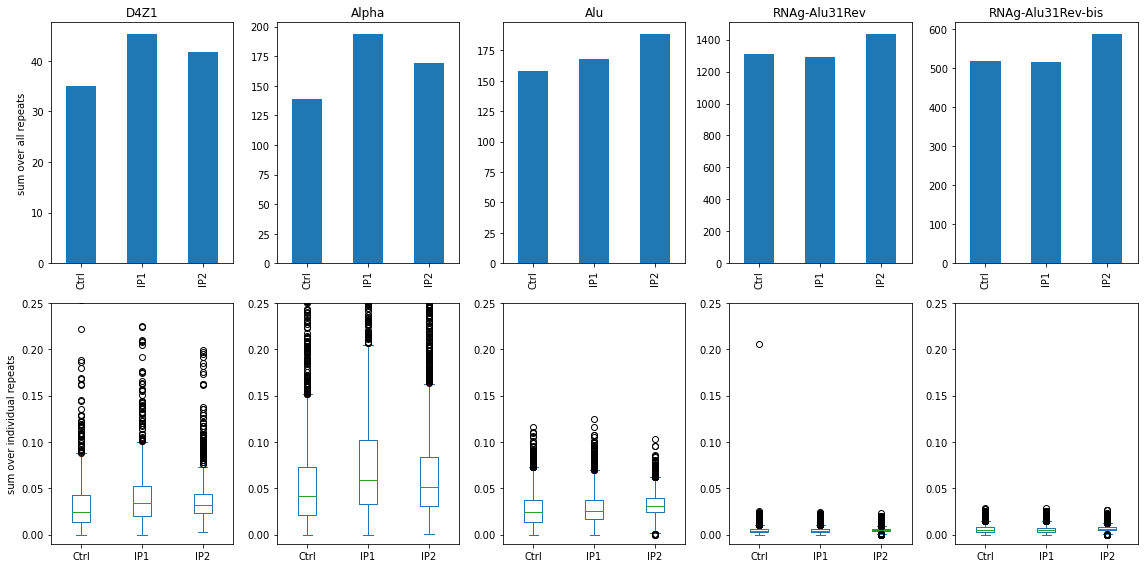

In [38]:
fig, axes = plt.subplots(2, 5, figsize=(16, 8), facecolor="w", layout="tight")
res = {}
for (repeat_element, bedfile), (ax1, ax2) in zip(resbedfiles.items(), axes.T):
    df = pd.read_csv(bedfile, sep="\t", header=None)
    df = (
        df.iloc[:, 3:].rename(
            {i + 3: bwfile for i, bwfile in enumerate(bwfiles.values())}, axis=1
        )
        * 1_000_000
        / Total_cov.loc[:, "Total_counts"]
    ).rename({bwfile: file_id for file_id, bwfile in bwfiles.items()}, axis=1)
    df.sum(axis=0).plot(kind="bar", ax=ax1)
    df.plot(kind="box", ax=ax2)
    ax1.set_title(repeat_element)
    ax2.set_ylim((-0.01, 0.25))
    res_rep = pd.DataFrame(
        {"sum": df.sum(axis=0), "mean": df.mean(axis=0), "std": df.std(axis=0)}
    )
    res[repeat_element] = res_rep
axes[0, 0].set_ylabel("sum over all repeats")
axes[1, 0].set_ylabel("sum over individual repeats")

Ctrl    35.100207
IP1     45.309816
IP2     41.667026
dtype: float64
Ctrl    138.597026
IP1     193.819942
IP2     168.856159
dtype: float64
Ctrl    158.383983
IP1     167.487063
IP2     188.495060
dtype: float64
Ctrl    1309.395478
IP1     1291.040974
IP2     1435.960357
dtype: float64
Ctrl    519.931851
IP1     515.503150
IP2     588.754391
dtype: float64


Text(0, 0.5, 'enrichment over INPUT (%)')

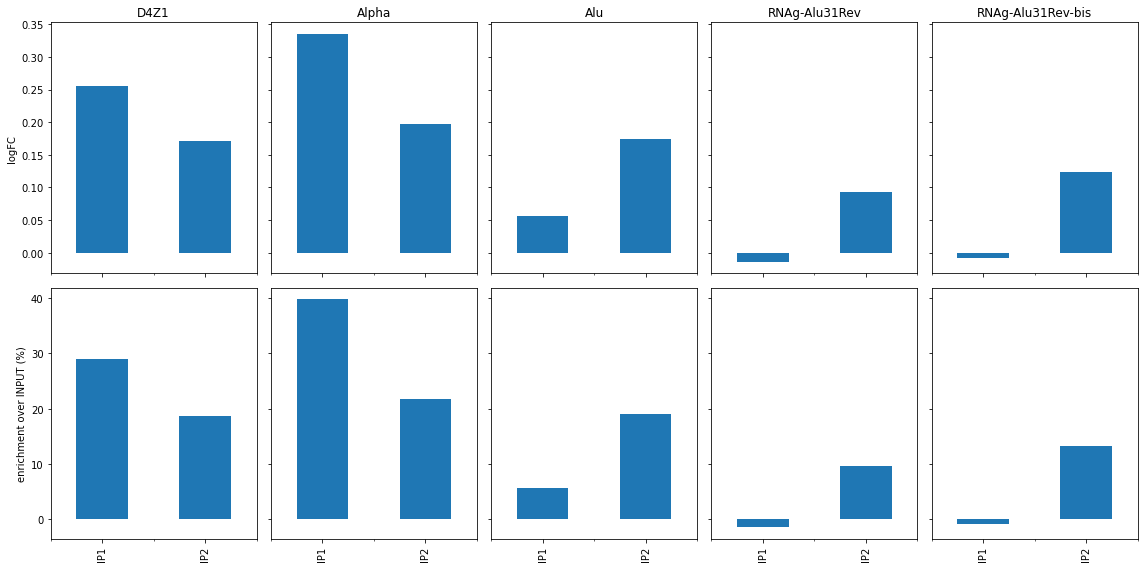

In [47]:
fig, axes = plt.subplots(
    2, 5, figsize=(16, 8), facecolor="w", layout="tight", sharex=True, sharey="row"
)
for (repeat_element, bedfile), (ax1, ax2) in zip(resbedfiles.items(), axes.T):
    df = pd.read_csv(bedfile, sep="\t", header=None)
    df = (
        df.iloc[:, 3:].rename(
            {i + 3: bwfile for i, bwfile in enumerate(bwfiles.values())}, axis=1
        )
        * 1_000_000
        / Total_cov.loc[:, "Total_counts"]
    ).rename({bwfile: file_id for file_id, bwfile in bwfiles.items()}, axis=1)
    sums = df.sum(axis=0)
    print(sums)
    suffix = ""  # "_pp1_mm3"  # '_pp1' #
    logFC = np.log(sums.loc[f"IP1{suffix}" : f"IP2{suffix}"] / sums[f"Ctrl{suffix}"])
    logFC.plot(kind="bar", ax=ax1)
    perc = (
        100
        * (sums.loc[f"IP1{suffix}" : f"IP2{suffix}"] - sums[f"Ctrl{suffix}"])
        / sums[f"Ctrl{suffix}"]
    )
    perc.plot(kind="bar", ax=ax2)
    ax1.set_title(repeat_element)
    # ax2.set_ylim((-0.01, 0.25))
axes[0, 0].set_ylabel("logFC")
axes[1, 0].set_ylabel("enrichment over INPUT (%)")

In [61]:
for (repeat_element, bedfile), (ax1, ax2) in zip(resbedfiles.items(), axes.T):
    df = pd.read_csv(bedfile, sep="\t", header=None)
    df = df.rename({i + 3: bwfile for i, bwfile in enumerate(bwfiles.values())}, axis=1)
    df.iloc[:, 3:] = df.iloc[:, 3:] * 1_000_000 / Total_cov.loc[:, "Total_counts"]
    df.drop([1, 2], axis=1, inplace=True)
    df = df.rename({bwfile: file_id for file_id, bwfile in bwfiles.items()}, axis=1)
df

,0,Ctrl,IP1,IP2
0,NC_060925.1,0.007631,0.007058,0.008286
1,NC_060925.1,0.000000,0.014339,0.008847
2,NC_060925.1,0.011351,0.008172,0.010038
3,NC_060925.1,0.006582,0.004458,0.008907
4,NC_060925.1,0.003815,0.002006,0.003497
...,...,...,...,...
93885,NC_060948.1,0.001908,0.000892,0.002406
93886,NC_060948.1,0.003815,0.007429,0.002767
93887,NC_060948.1,0.001908,0.002972,0.005595
93888,NC_060948.1,0.000000,0.004458,0.004091


In [64]:
sums = df.groupby(0).aggregate("sum")
sums

,Ctrl,IP1,IP2
0,,,
NC_060925.1,46.079967,43.382283,49.386002
NC_060926.1,37.461682,36.061222,41.366247
NC_060927.1,29.525266,28.946175,32.946857
NC_060928.1,23.459659,23.123233,26.264711
NC_060929.1,25.757464,25.542475,29.843627
NC_060930.1,25.292600,25.262205,28.671787
NC_060931.1,28.838581,28.848331,32.971145
NC_060932.1,20.109982,19.877221,22.766314
NC_060933.1,22.237237,21.952560,24.996621


In [70]:
suffix = ""
sums.loc[:, f"IP1{suffix}" : f"IP2{suffix}"] - sums.loc[:, f"Ctrl{suffix}"]
# perc = (
#     100
#     * (sums.loc[:, f"IP1{suffix}" : f"IP2{suffix}"] - sums.loc[:, f"Ctrl{suffix}"])
#     / sums.loc[:, f"Ctrl{suffix}"]
# )
# perc

,IP1,IP2,NC_060925.1,NC_060926.1,NC_060927.1,NC_060928.1,NC_060929.1,NC_060930.1,NC_060931.1,NC_060932.1,...,NC_060939.1,NC_060940.1,NC_060941.1,NC_060942.1,NC_060943.1,NC_060944.1,NC_060945.1,NC_060946.1,NC_060947.1,NC_060948.1
0,,,,,,,,,,,,,,,,,,,,,
NC_060925.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NC_060926.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NC_060927.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NC_060928.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NC_060929.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NC_060930.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NC_060931.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NC_060932.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NC_060933.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
